# <font color='#154360'> <center> FUNCTIONAL API </center> </font>

TABLKE OF CONTENTS...

<a name="1"></a>
## <font color='blue'> 1. Introduction </font>

This notebook demonstrates how to use the Keras Functional API to build neural networks. Through a few simple examples, we will explore how it provides more flexibility than the Sequential API, allowing for multiple inputs, multiple outputs, and shared layers.

<a name="2"></a>
## <font color='blue'> Setup </font>

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, Lambda
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
import random
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop

In [2]:
# Set seed for Python’s built-in random module
random.seed(42)

# Set seed for NumPy
np.random.seed(42)

# Set seed for TensorFlow
tf.random.set_seed(42)

<a name="fds"></a>
## <font color='blue'> 3. Basic example </font>

We will write a simple Sequential model and then rewrite it using the Functional API.

### Sequential model

In [91]:
# Using Sequential API
def sequential_api_model():
    model = Sequential([
        Input(shape=(5,)),  # Input layer with 5 features
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Output layer
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# instanciate
seq_model = sequential_api_model()


# Print summary
seq_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 128)               768       
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dense_35 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9089 (35.50 KB)
Trainable params: 9089 (35.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Functional API

In [88]:
# Using Functional API
def functional_api_model():
    input_layer = Input(shape=(5,))
    x = Dense(128, activation='relu')(input_layer)
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# instanciate
func_model = functional_api_model()

# Print summary
func_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_24 (Dense)            (None, 128)               768       
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9089 (35.50 KB)
Trainable params: 9089 (35.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Note that with the Functional API the `summary` method also prints the input layer.

<a name="fds"></a>
## <font color='blue'> 4. Multi-output model </font>

### <font color='#1f618d'> Helper Functions </font>

In [60]:
# plot history
def plot_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 5))

   

    # Plot RMSE values
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['y1_output_root_mean_squared_error'], label='Train y1 RMSE')
    plt.plot(history.history['val_y1_output_root_mean_squared_error'], label='Val y1 RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.title('y1 RMSE')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['y2_output_root_mean_squared_error'], label='Train y2 RMSE')
    plt.plot(history.history['val_y2_output_root_mean_squared_error'], label='Val y2 RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.title('y2 RMSE')

    plt.show()

### <font color='#1f618d'> Data </font>

We will create synthetic data.

The data will have:
- 5 features
- 2 targets

In [36]:
# Generate features and two target variables
X = np.random.rand(100, 5)

# Generate two target variables for each sample
y1 = X[:, 0] * 3 + X[:, 1] * 2 + X[:, 2] * 0.5 + np.random.normal(0, 0.1, 100)  # A random function of X
y2 = X[:, 3] * 4 + X[:, 4] * 1.5 + np.random.normal(0, 0.1, 100)  # Another random function of X

# Create a DataFrame for features
data = pd.DataFrame(X, columns=['X1', 'X2', 'X3', 'X4', 'X5'])
data['y1'] = y1
data['y2'] = y2

# Split the features and targets and convert to numpy arrays
X_features = data[['X1', 'X2', 'X3', 'X4', 'X5']].values  # Convert to numpy array
y1_target = data['y1'].values  # Convert to numpy array
y2_target = data['y2'].values  # Convert to numpy array

# Train/test split (80% train, 20% test)
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X_features, 
                                                                          y1_target, 
                                                                          y2_target, 
                                                                          test_size=0.2, 
                                                                          random_state=42)

# Verify the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y1_train shape:", y1_train.shape)
print("y1_test shape:", y1_test.shape)
print("y2_train shape:", y2_train.shape)
print("y2_test shape:", y2_test.shape)


X_train shape: (80, 5)
X_test shape: (20, 5)
y1_train shape: (80,)
y1_test shape: (20,)
y2_train shape: (80,)
y2_test shape: (20,)


### <font color='#1f618d'> Build, compile, train and evaluate the model </font>

We will build the following model:


<img src="images/multiple_outputs.png"/>

### Build

In [66]:
# Build model
def build_model(input_shape):
    # Define model layers.
    input_layer = Input(shape=(input_shape,))
    first_dense = Dense(units='128', activation='relu')(input_layer)
    second_dense = Dense(units='128', activation='relu')(first_dense)

    # Y1 output will be fed directly from the second dense
    y1_output = Dense(units='1', name='y1_output')(second_dense)
    third_dense = Dense(units='64', activation='relu')(second_dense)

    # Y2 output will come via the third dense
    y2_output = Dense(units='1', name='y2_output')(third_dense)

    # Define the model with the input layer and a list of output layers
    model = Model(inputs=input_layer, outputs=[y1_output, y2_output])
    
    return model

model = build_model(X_train.shape[1])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 dense_9 (Dense)             (None, 128)                  768       ['input_4[0][0]']             
                                                                                                  
 dense_10 (Dense)            (None, 128)                  16512     ['dense_9[0][0]']             
                                                                                                  
 dense_11 (Dense)            (None, 64)                   8256      ['dense_10[0][0]']            
                                                                                            

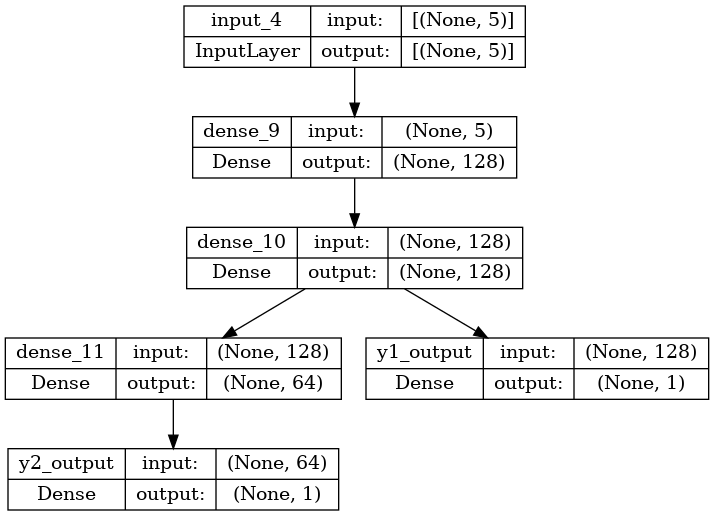

In [67]:
# plot the model
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

### Compile

In [68]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001)

model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

### Train

In [69]:
history = model.fit(X_train, {'y1_output': y1_train, 'y2_output': y2_train}, 
                    epochs=100, batch_size=32, 
                    verbose=0,
                    validation_data=(X_test, {'y1_output': y1_test, 'y2_output': y2_test}))

In [70]:
# keys in history
print(history.history.keys())

dict_keys(['loss', 'y1_output_loss', 'y2_output_loss', 'y1_output_root_mean_squared_error', 'y2_output_root_mean_squared_error', 'val_loss', 'val_y1_output_loss', 'val_y2_output_loss', 'val_y1_output_root_mean_squared_error', 'val_y2_output_root_mean_squared_error'])


In [71]:
# last values in history

last_loss = history.history['loss'][-1]  # Last training loss
last_val_loss = history.history['val_loss'][-1]  # Last validation loss

last_y1_loss = history.history['y1_output_loss'][-1]  # Last y1 training loss
last_y2_loss = history.history['y2_output_loss'][-1]  # Last y2 training loss

last_y1_rmse = history.history['y1_output_root_mean_squared_error'][-1]  # Last y1 RMSE
last_y2_rmse = history.history['y2_output_root_mean_squared_error'][-1]  # Last y2 RMSE

print("Last Training Loss:", last_loss)
print("Last Validation Loss:", last_val_loss)
print("Last y1 Loss:", last_y1_loss)
print("Last y2 Loss:", last_y2_loss)
print("Last y1 RMSE:", last_y1_rmse)
print("Last y2 RMSE:", last_y2_rmse)


Last Training Loss: 1.2763093709945679
Last Validation Loss: 1.0364199876785278
Last y1 Loss: 0.5005489587783813
Last y2 Loss: 0.7757604718208313
Last y1 RMSE: 0.707494854927063
Last y2 RMSE: 0.8807726502418518


<Figure size 1200x500 with 0 Axes>

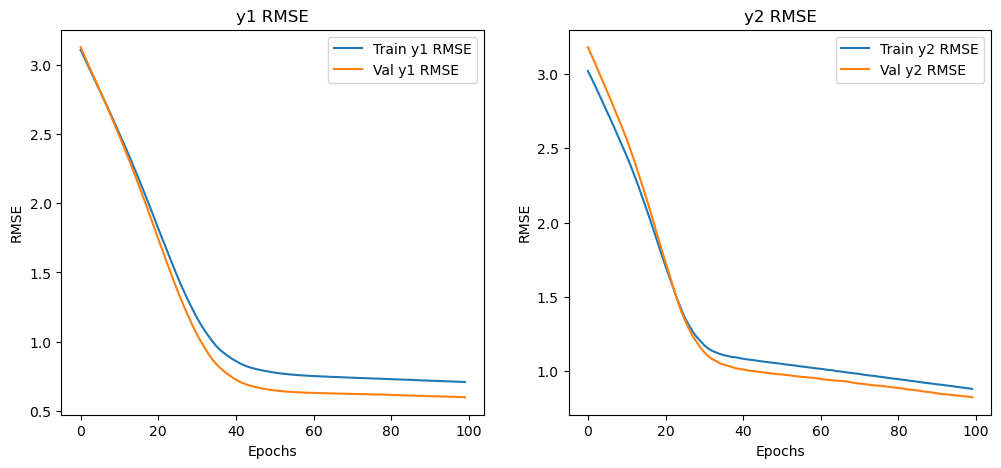

In [72]:
# Plot history
plot_history(history)

### Evaluate

In [73]:
# Evaluate the model on the test data
loss, y1_loss, y2_loss, y1_mae, y2_mae = model.evaluate(X_test, 
                                                          {'y1_output': y1_test, 'y2_output': y2_test})

# Print the results
print(f"Test Loss: {loss}")
print(f"Y1 Output Loss: {y1_loss}")
print(f"Y2 Output Loss: {y2_loss}")
print(f"Y1 MAE: {y1_mae}")
print(f"Y2 MAE: {y2_mae}")

1/1 [==============================] - 0s 21ms/step - loss: 1.0364 - y1_output_loss: 0.3568 - y2_output_loss: 0.6796 - y1_output_root_mean_squared_error: 0.5974 - y2_output_root_mean_squared_error: 0.8244
Test Loss: 1.0364199876785278
Y1 Output Loss: 0.3568285405635834
Y2 Output Loss: 0.6795914769172668
Y1 MAE: 0.5973512530326843
Y2 MAE: 0.8243733644485474


### <font color='#1f618d'> Making predictions </font>

In [80]:
# Predicting for a single sample (make sure the input is 2D even for one sample)
single_sample = X_test[0].reshape(1, -1)  # Reshape to (1, input_shape)

# Make a prediction for the single sample
y1_single_pred, y2_single_pred = model.predict(single_sample)

# Print the predictions for y1 and y2
print("Predicted Y1 for single sample:", y1_single_pred)
print("Predicted Y2 for single sample:", y2_single_pred)


1/1 [==============================] - 0s 15ms/step
Predicted Y1 for single sample: [[2.7449756]]
Predicted Y2 for single sample: [[3.1618426]]


In [81]:
# batch
model.predict(X_test[:3])

1/1 [==============================] - 0s 16ms/step


[array([[2.7449758],
        [3.1461146],
        [2.8424618]], dtype=float32),
 array([[3.1618423],
        [2.591908 ],
        [2.1284838]], dtype=float32)]

<a name="5"></a>
## <font color='blue'> 5. Siamese network </font>

helepr functions


data


primero la voy a hacer con su dataset y luego voy a cambiar

### <font color='#1f618d'> Data </font>

Yes, for a Siamese network, you need to prepare pairs of inputs. Each pair consists of:

A left input (input_a)
A right input (input_b)
A label (y), indicating whether the two inputs are similar (1) or dissimilar (0).

In [3]:

from tensorflow.keras.datasets import mnist

# Load dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize images
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# Function to create pairs
def create_pairs(images, labels, num_pairs=50000):
    pairs = []
    labels_list = []
    num_classes = len(np.unique(labels))  # 10 for MNIST digits
    digit_indices = [np.where(labels == i)[0] for i in range(num_classes)]  # Indices of each class

    for _ in range(num_pairs // 2):  # Half will be positive, half negative
        # Positive pair (same class)
        # the code selects two images from the same class (using digit_indices[label])
        label = np.random.randint(0, num_classes)
        i1, i2 = np.random.choice(digit_indices[label], size=2, replace=False)
        pairs.append([images[i1], images[i2]])
        labels_list.append(1)  # Similar

        
        
        # Negative pair (different class)
        label1, label2 = np.random.choice(num_classes, size=2, replace=False)
        i1 = np.random.choice(digit_indices[label1])
        i2 = np.random.choice(digit_indices[label2])
        pairs.append([images[i1], images[i2]])
        labels_list.append(0)  # Dissimilar

    return np.array(pairs), np.array(labels_list)

# Create train and test pairs
train_pairs, train_targets = create_pairs(train_images, train_labels, num_pairs=50000)
test_pairs, test_targets = create_pairs(test_images, test_labels, num_pairs=10000)

# Reshape for model input
train_left, train_right = train_pairs[:, 0], train_pairs[:, 1]
test_left, test_right = test_pairs[:, 0], test_pairs[:, 1]


In [4]:
def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [8]:
train_pairs.shape # 50000 imaggenes, con cada par conteniendo imagenes de 28x28

(50000, 2, 28, 28)

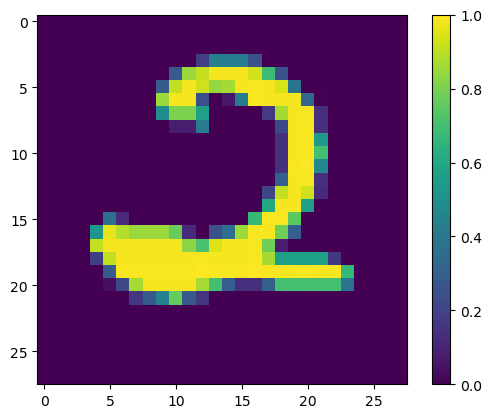

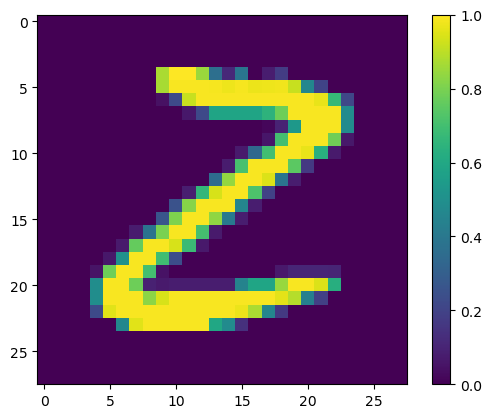

1


In [9]:
# array index
this_pair = 8

# show images at this index
show_image(train_pairs[this_pair][0])
show_image(train_pairs[this_pair][1])

# print the label for this pair
print(train_targets[this_pair])

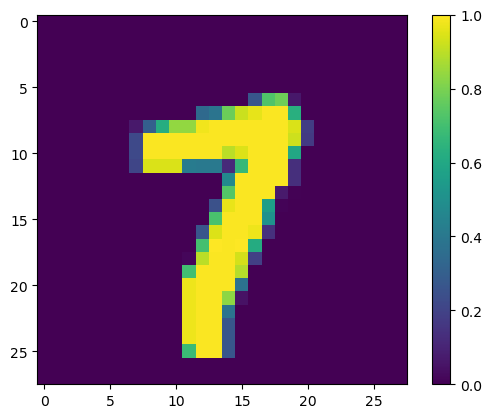

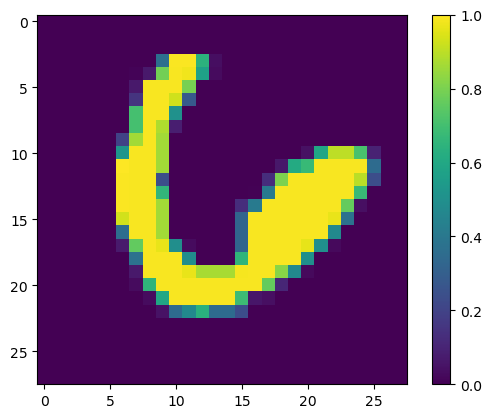

0


In [10]:
# array index
this_pair = 17

# show images at this index
show_image(train_pairs[this_pair][0])
show_image(train_pairs[this_pair][1])

# print the label for this pair
print(train_targets[this_pair])

### <font color='#1f618d'> Model </font>

In [14]:
def initialize_base_network():
    input = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

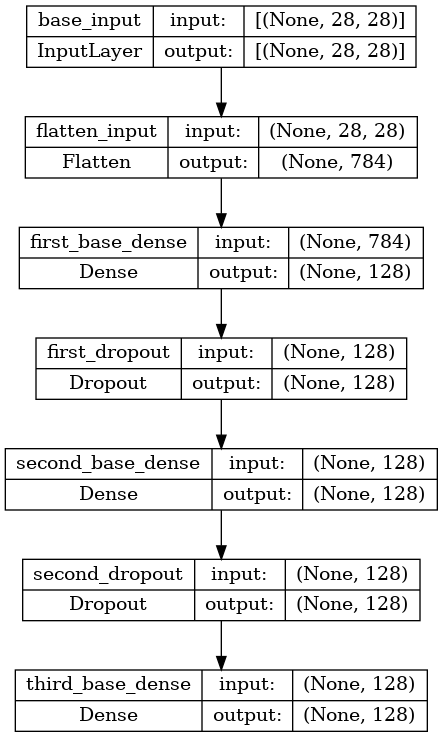

In [15]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

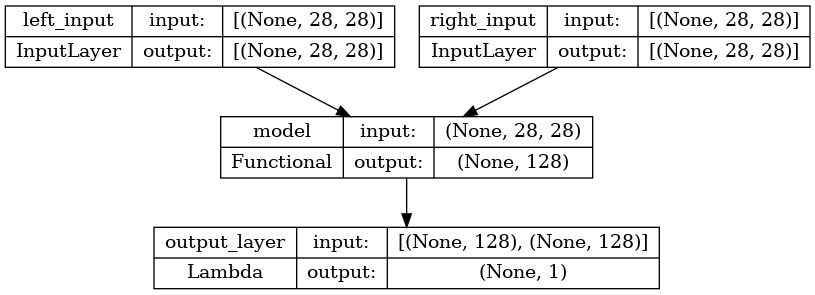

In [36]:
# create the left input and point to the base network
input_a = Input(shape=(28,28,), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

# plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

In [37]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        y_true = K.cast(y_true, K.floatx())  # Ensure y_true is float32
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss





In [38]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)

In [39]:
history = model.fit([train_left, train_right], train_targets, 
          validation_data=([test_left, test_right], test_targets), 
          epochs=10, 
          batch_size=128)


Epoch 1/10
391/391 [==============================] - 3s 5ms/step - loss: 0.0159 - val_loss: 0.0272
Epoch 2/10
391/391 [==============================] - 2s 5ms/step - loss: 0.0149 - val_loss: 0.0267
Epoch 3/10
391/391 [==============================] - 2s 5ms/step - loss: 0.0136 - val_loss: 0.0289
Epoch 4/10
391/391 [==============================] - 2s 5ms/step - loss: 0.0129 - val_loss: 0.0286
Epoch 5/10
391/391 [==============================] - 2s 5ms/step - loss: 0.0123 - val_loss: 0.0273
Epoch 6/10
391/391 [==============================] - 2s 5ms/step - loss: 0.0112 - val_loss: 0.0288
Epoch 7/10
391/391 [==============================] - 2s 5ms/step - loss: 0.0108 - val_loss: 0.0278
Epoch 8/10
391/391 [==============================] - 2s 5ms/step - loss: 0.0102 - val_loss: 0.0293
Epoch 9/10
391/391 [==============================] - 2s 5ms/step - loss: 0.0102 - val_loss: 0.0291
Epoch 10/10
391/391 [==============================] - 2s 5ms/step - loss: 0.0098 - val_loss: 0.0304

In [40]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [41]:
loss = model.evaluate(x=[train_left,train_right], y=train_targets)


y_pred_train = model.predict([train_left, train_right])
train_accuracy = compute_accuracy(train_targets, y_pred_train)

y_pred_test = model.predict([test_left, test_right])
test_accuracy = compute_accuracy(test_targets, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

313/313 [==============================] - 0s 1ms/step
Loss = 0.005248678382486105, Train Accuracy = 0.99592 Test Accuracy = 0.9665


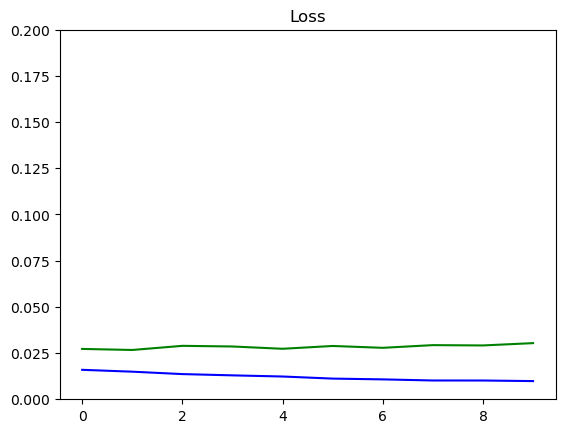

In [44]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [46]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)



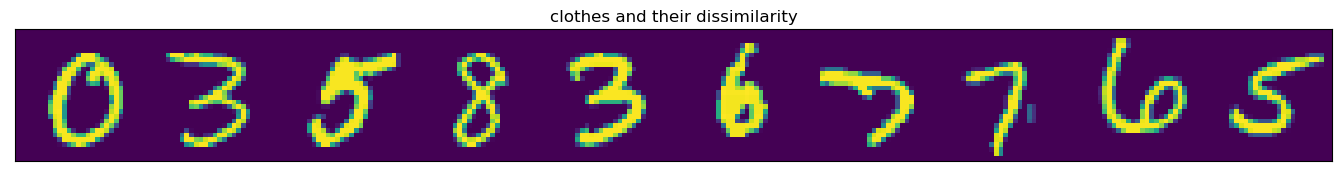

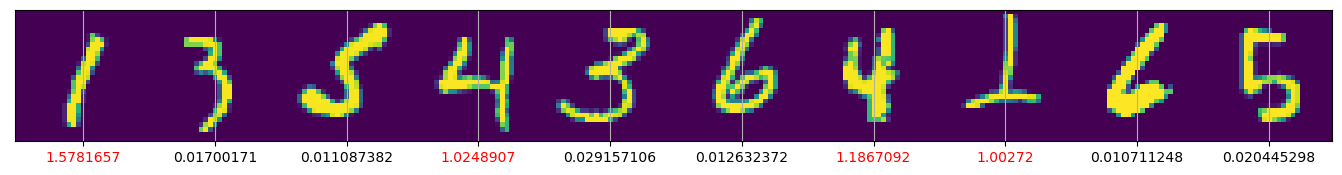

In [47]:
y_pred_train = np.squeeze(y_pred_train)

indexes = np.random.choice(len(y_pred_train), size=10)

display_images(train_left[indexes], train_right[indexes], y_pred_train[indexes], 
               train_targets[indexes], "clothes and their dissimilarity", 10)

In [48]:
y_pred_train[0]

0.008080805

In [54]:
input_ = [train_left[0].reshape(1, -1), train_right[0].reshape(1, -1)]




model.predict(input_)



1/1 [==============================] - 0s 17ms/step


array([[0.0080808]], dtype=float32)

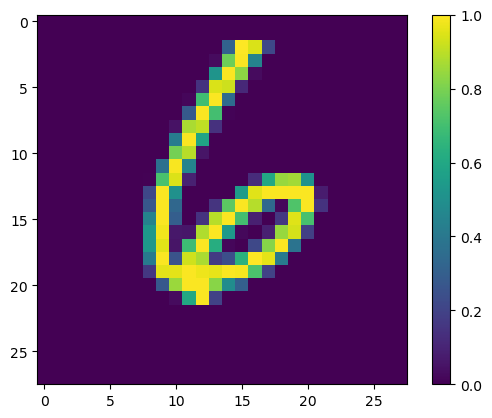

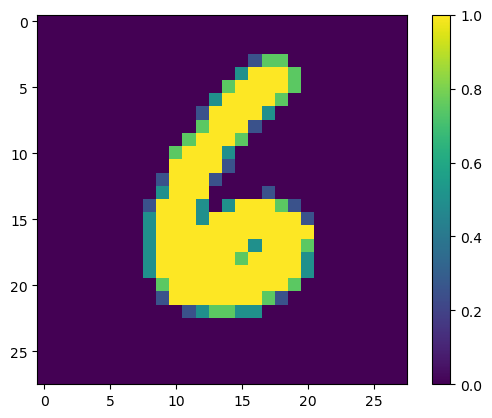

In [56]:


# show images at this index
show_image(train_left[0])
show_image(train_right[0])


In [57]:
input_ = [train_left[7].reshape(1, -1), train_right[7].reshape(1, -1)]


model.predict(input_)

1/1 [==============================] - 0s 18ms/step


array([[1.3669146]], dtype=float32)

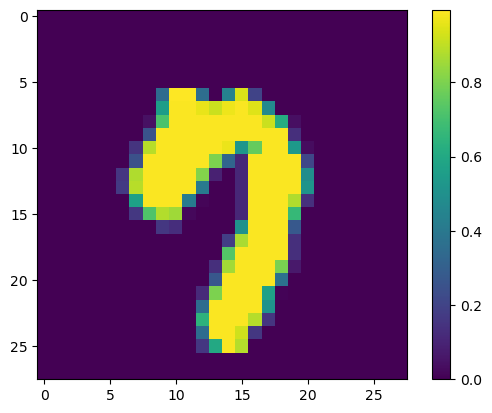

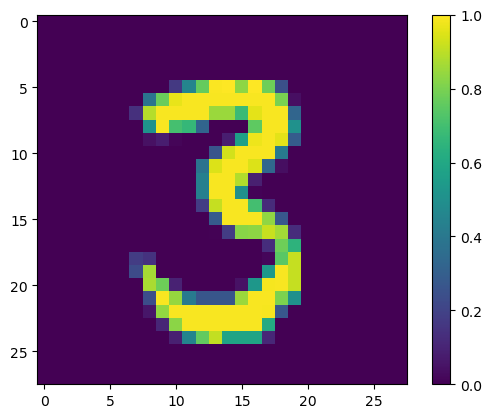

In [58]:
# show images at this index
show_image(train_left[7])
show_image(train_right[7])


distancia cercana a 0 quiere decir que son lo mismo (la distancia euclide aentre ellos es pequeña)

In [ ]:
import numpy as np

def create_pairs(images, labels, num_pairs=50000):
    """
    Creates pairs of images for training a Siamese network. The pairs can be:
    - Positive pairs: Images of the same class (labeled as 1).
    - Negative pairs: Images from different classes (labeled as 0).
    
    Args:
    images (numpy.ndarray): Array of images to generate pairs from.
    labels (numpy.ndarray): Array of labels corresponding to the images.
    num_pairs (int): The total number of pairs to generate. Default is 50000.
    
    Returns:
    tuple: A tuple containing two elements:
        - pairs (numpy.ndarray): A 3D array of shape (num_pairs, 2, image_shape).
        - labels_list (numpy.ndarray): A 1D array of labels (0 or 1) for each pair.
    """
    pairs = []  # List to store the image pairs
    labels_list = []  # List to store the corresponding labels for the pairs (1 for similar, 0 for dissimilar)
    
    num_classes = len(np.unique(labels))  # Get the number of unique classes (e.g., 10 for MNIST digits)
    
    # Create a list of indices for each class in the dataset
    digit_indices = [np.where(labels == i)[0] for i in range(num_classes)]
    
    # Generate pairs
    for _ in range(num_pairs // 2):  # Half will be positive pairs, half will be negative
        # Positive pair (same class)
        label = np.random.randint(0, num_classes)  # Randomly choose a class
        i1, i2 = np.random.choice(digit_indices[label], size=2, replace=False)  # Choose two distinct images from the same class
        pairs.append([images[i1], images[i2]])  # Add the pair to the pairs list
        labels_list.append(1)  # Label as 1 (similar)
        
        # Negative pair (different class)
        label1, label2 = np.random.choice(num_classes, size=2, replace=False)  # Randomly choose two different classes
        i1 = np.random.choice(digit_indices[label1])  # Choose one image from the first class
        i2 = np.random.choice(digit_indices[label2])  # Choose one image from the second class
        pairs.append([images[i1], images[i2]])  # Add the pair to the pairs list
        labels_list.append(0)  # Label as 0 (dissimilar)
    
    # Return the pairs and the corresponding labels as numpy arrays
    return np.array(pairs), np.array(labels_list)
